In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold

In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time

In [5]:
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

## Load dataset

In [7]:
path_out = r'F:\Codes\joint attention\Nano-particle\output_new_new'

file_path_features_norm = os.path.join(path_out , 'features_normalized_35.npy')
file_path_labels = os.path.join(path_out , 'label_r_avg_raw.npy')
file_path_features_original = os.path.join(path_out , 'features_raw_35.npy')

with open( file_path_features_original , 'rb') as f:
    features_orig = np.load(f)
with open( file_path_labels , 'rb') as f:
    labels = np.load(f)
with open( file_path_features_norm , 'rb') as f:
    features_norm = np.load(f)

print(features_orig.shape)
print(labels.shape)
print(features_norm.shape)

(3999, 35)
(3999, 1)
(3999, 35)


## Visualize data

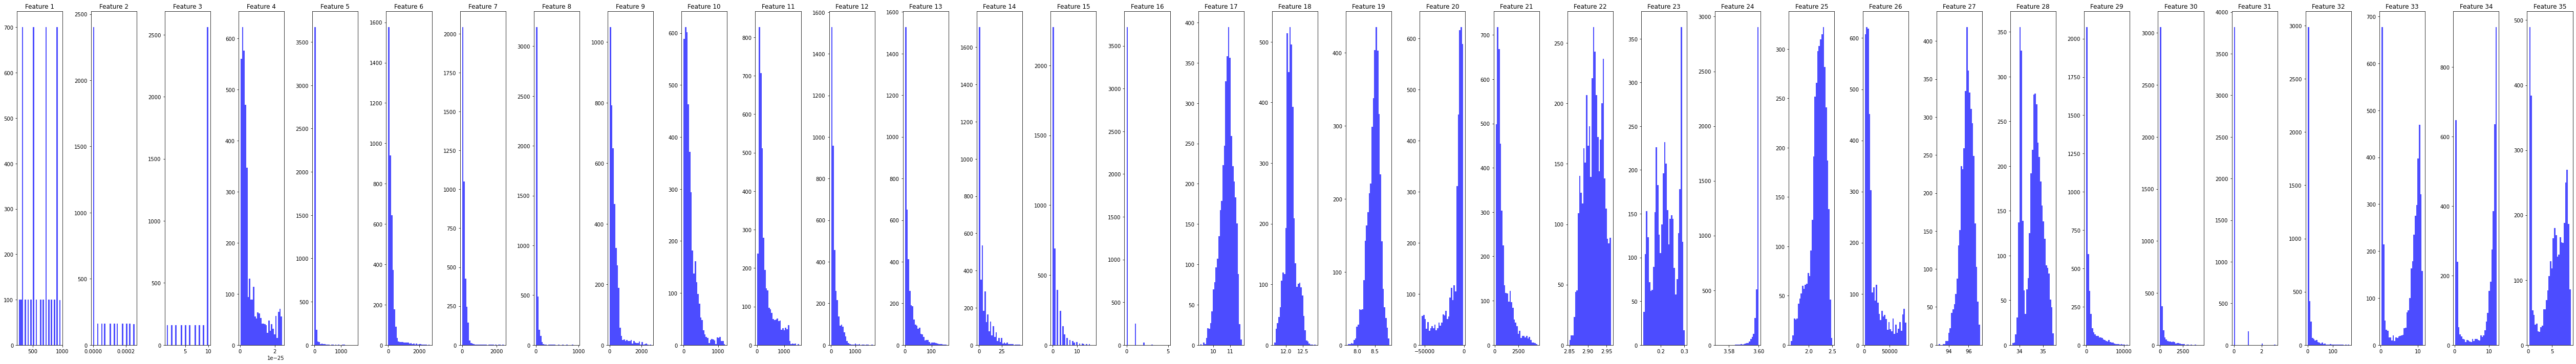

In [8]:
data = features_orig
fig, axs = plt.subplots(nrows=1, ncols=35, figsize=(70, 10))
for i in range(35):
    axs[i].hist(data[:, i], bins=30, color='blue', alpha=0.7)
    axs[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

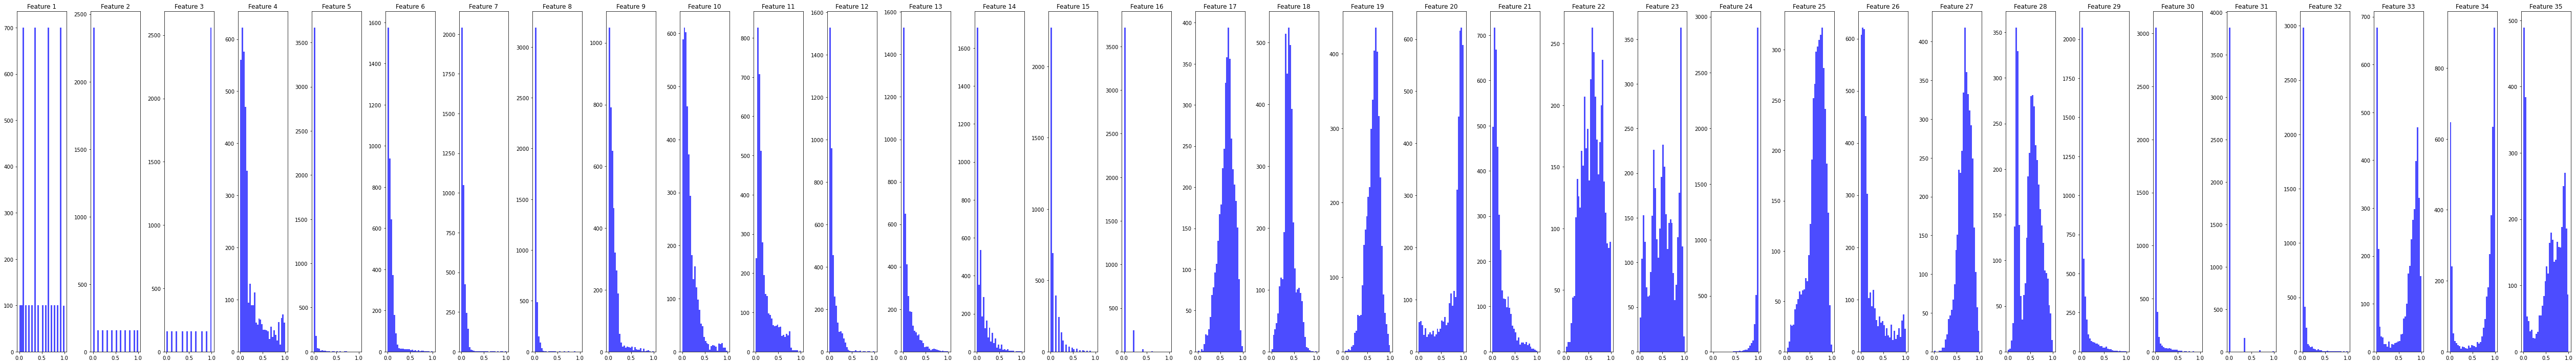

In [9]:
data = features_norm
fig, axs = plt.subplots(nrows=1, ncols=35, figsize=(70, 10))
for i in range(35):
    axs[i].hist(data[:, i], bins=30, color='blue', alpha=0.7)
    axs[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

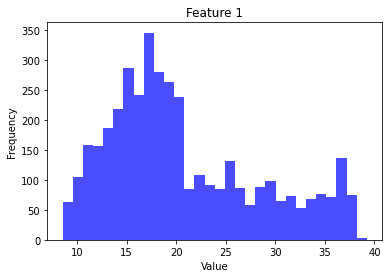

In [10]:
data = labels
plt.hist(data[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Feature 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Split the dataset into train , test and validation splits

In [11]:
# Split data into train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features_norm, labels, test_size=0.2, random_state=42)

print(f"features train shape: {features_train.shape}")
print(f"features test shape: {features_test.shape}") # tmp 
print(f"labels train shape: {labels_train.shape}")
print(f"labes test shape: {labels_test.shape}") # tmp

print(f"features train type: {type(features_train)}")
print(f"features test type: {type(features_test)}")
print(f"labels train type: {type(labels_train)}")
print(f"labes test type: {type(labels_test)}")

#test set again split into actual test and validation sets
features_validation, features_test, labels_validation, labels_test = train_test_split(features_test, labels_test, test_size=0.5, random_state=42)

print(f"features validation shape: {features_validation.shape}")
print(f"features test shape: {features_test.shape}")
print(f"labels validation shape: {labels_validation.shape}")
print(f"labes test shape: {labels_test.shape}")

print(f"features validation type: {type(features_validation)}")
print(f"features test type: {type(features_test)}")
print(f"labels validation type: {type(labels_validation)}")
print(f"labes test type: {type(labels_test)}")

features train shape: (3199, 35)
features test shape: (800, 35)
labels train shape: (3199, 1)
labes test shape: (800, 1)
features train type: <class 'numpy.ndarray'>
features test type: <class 'numpy.ndarray'>
labels train type: <class 'numpy.ndarray'>
labes test type: <class 'numpy.ndarray'>
features validation shape: (400, 35)
features test shape: (400, 35)
labels validation shape: (400, 1)
labes test shape: (400, 1)
features validation type: <class 'numpy.ndarray'>
features test type: <class 'numpy.ndarray'>
labels validation type: <class 'numpy.ndarray'>
labes test type: <class 'numpy.ndarray'>


## Model Training

## XGBoost (without hyper-parameter tuning)

In [21]:
# X_train, X_test, y_train, y_test = features_train,features_validation,labels_train,labels_validation

dtrain = xgb.DMatrix(features_train, label=labels_train)
dtest = xgb.DMatrix(features_test, label=labels_test)

params = {
    'max_depth': 3,              # the maximum depth of each tree
    'eta': 0.3,                  # the training step for each iteration
    'objective': 'reg:squarederror',  # regression with squared loss
}

num_rounds = 20

training_start = time.time()
bst = xgb.train(params, dtrain, num_rounds)
training_end = time.time()

testing_start = time.time()
preds = bst.predict(dtest)
testing_end = time.time()


mse = mean_squared_error(y_test, preds)
print("MSE: %.10f" % mse)
r2 = r2_score(y_test, preds)
print(f"R^2: {r2:.10f}")

print("Time taken for training: {:.10f} seconds".format(training_end - training_start))
print("Time taken for testing: {:.10f} seconds".format(testing_end - testing_start))

MSE: 0.0902745647
R^2: 0.9983632739
Time taken for training: 0.0767943859 seconds
Time taken for testing: 0.0009982586 seconds


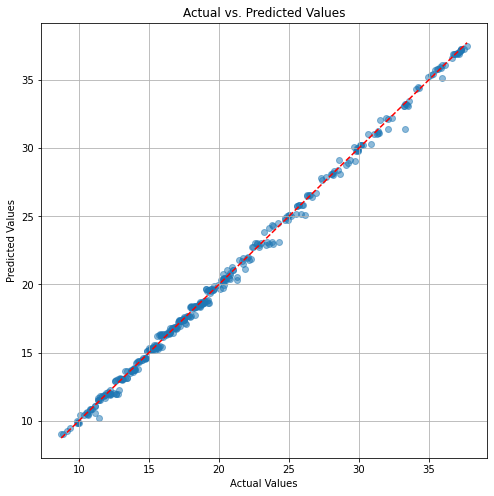

In [22]:
predicted_values = preds
actual_values = y_test
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

min_val = min(np.min(actual_values), np.min(predicted_values))
max_val = max(np.max(actual_values), np.max(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.grid(True)
plt.show()

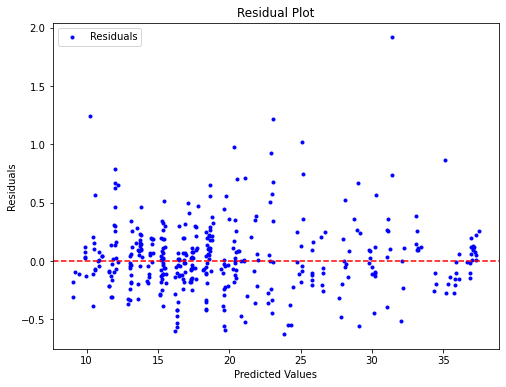

In [24]:
residuals = actual_values.squeeze() - predicted_values

plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, color='blue', marker='.', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend(loc='upper left')
plt.show()

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7}

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'eta': [0.01, 0.1, 0.2]
# }

# # param_grid = {
# #     'max_depth': [3, 4],
# #     'min_child_weight': [1, 2]
# # }

# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)

In [36]:
# best parameters used for 
X_train, X_test, y_train, y_test = features_train,features_validation,labels_train,labels_validation


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# params = {
#     'max_depth': 3,              # the maximum depth of each tree
#     'eta': 0.3,                  # the training step for each iteration
#     'objective': 'reg:squarederror',  # regression with squared loss
# }


params = {'colsample_bytree': 0.8, 
          'eta': 0.1, 
          'gamma': 0, 
          'max_depth': 5, 
          'min_child_weight': 2, 
          'subsample': 0.7, 
          'objective': 'reg:squarederror'}


num_rounds = 20


training_start = time.time()
bst = xgb.train(params, dtrain, num_rounds)
training_end = time.time()


testing_start = time.time()
preds = bst.predict(dtest)
testing_end = time.time()


mse = mean_squared_error(y_test, preds)
print("MSE: %.10f" % mse)
r2 = r2_score(y_test, preds)
print(f"R^2: {r2:.10f}")


print("Time taken for training: {:.10f} seconds".format(training_end - training_start))
print("Time taken for testing: {:.10f} seconds".format(testing_end - testing_start))

MSE: 6.9412073251
R^2: 0.8741521991
Time taken for training: 0.0759983063 seconds
Time taken for testing: 0.0040001869 seconds


## AdaBoost

In [30]:
base_regressor = DecisionTreeRegressor(max_depth=3)

ada_reg = AdaBoostRegressor(base_estimator=base_regressor, n_estimators=100, random_state=42)

training_start = time.time()
ada_reg.fit(X_train, y_train)
training_end = time.time()

testing_start = time.time()
y_pred = ada_reg.predict(X_test)
testing_end = time.time()


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2:.10f}")


print("Time taken for training: {:.10f} seconds".format(training_end - training_start))
print("Time taken for testing: {:.10f} seconds".format(testing_end - testing_start))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Squared Error: 0.1969628395196179
R^2: 0.9964289584
Time taken for training: 2.6226828098 seconds
Time taken for testing: 0.0199487209 seconds


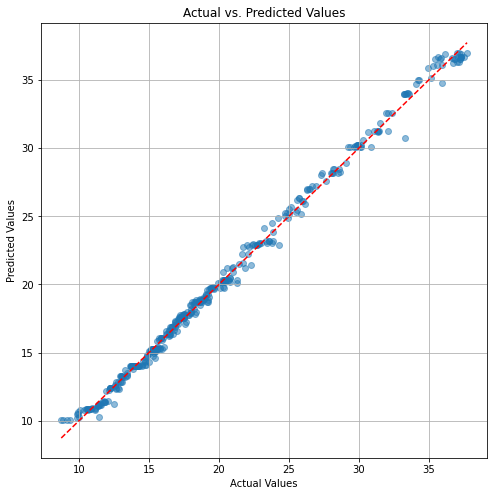

In [33]:
predicted_values = y_pred
actual_values = y_test
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

min_val = min(np.min(actual_values), np.min(predicted_values))
max_val = max(np.max(actual_values), np.max(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.grid(True)
plt.show()

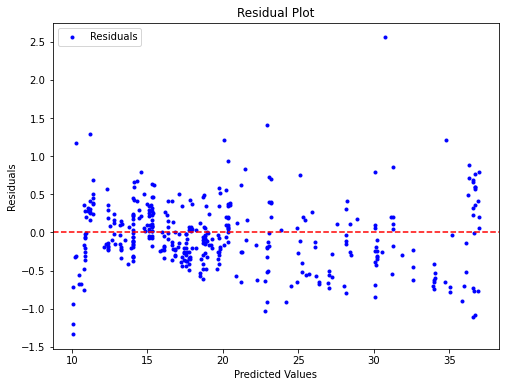

In [34]:
residuals = actual_values.squeeze() - predicted_values

plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, color='blue', marker='.', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend(loc='upper left')
plt.show()